 We will utilize the yfinance library to retrieve historical volatility data and implement GARCH on it 

 (Generealized AUtoRegressive Conditional Heteroskedaticity) model to estimate and forecast volatitlity

 Volatiltiy is a crucial aspect of financial markets as it measures the degree of variation in the price of a finanical instrument over time 

 Accurate volatility forecasting can assist traders and investors in making informed decisions and managingn risk efficiently

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import style
%matplotlib inline
import seaborn as sns 
from datetime import datetime 

import yfinance as yf 
from alpha_vantage.timeseries import TimeSeries

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

# we will see GoldMan Sachs time series data

fetching data from yahoo finance

stock = yf.Ticker("GS")

volatility_data = stock.history(period="max") # abhi tak ka 
sara data dega meko

In [2]:
# Using Timeseries to fetch Goldman Sachs data

api_key = "CXYJSJHR5SRVV0TR"
ts = TimeSeries(key=api_key, output_format="pandas")

In [3]:
# Get daily stock data for Goldman Sachs (GS)
volatility_data, meta_data = ts.get_daily(symbol="GS",outputsize="full")

In [4]:
print(volatility_data.tail())

            1. open  2. high  3. low  4. close  5. volume
date                                                     
1999-11-05    72.00    74.31   71.25     73.69  1304900.0
1999-11-04    69.69    70.75   69.44     70.13   570400.0
1999-11-03    69.81    69.88   68.31     68.75   924000.0
1999-11-02    69.19    71.75   69.13     69.75   543000.0
1999-11-01    70.50    71.00   69.31     69.38   949300.0


In [5]:
print(volatility_data.head())

            1. open   2. high    3. low  4. close  5. volume
date                                                        
2025-03-24   575.00  582.7200  573.0500    580.10  1877703.0
2025-03-21   555.33  567.0000  551.2079    565.14  3565589.0
2025-03-20   553.10  568.4355  552.0000    562.68  2531298.0
2025-03-19   549.00  563.0000  544.6000    557.34  2770144.0
2025-03-18   550.29  553.7500  546.6500    551.78  2641018.0


#### The columns represent:
1. Open: Opening price of the stock
2. High: Highest price during the trading day
3. Low: Lowest price during the trading day
4. Close: Closing price of the stock
5. Volume: Number of shares traded

In [6]:
df = volatility_data
df.rename(columns={"4. close":"close"},inplace=True)

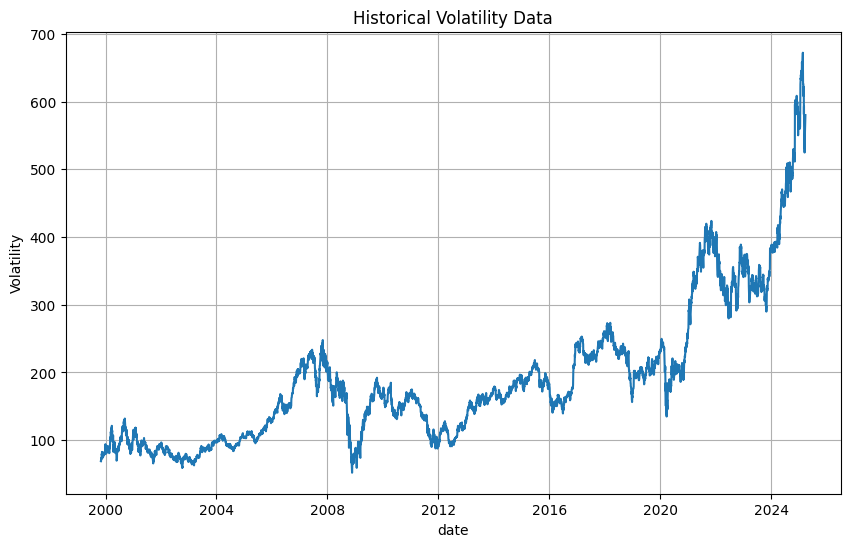

In [7]:
plt.figure(figsize=(10,6))
plt.plot(df.index,df["close"])
plt.xlabel("date")
plt.ylabel("Volatility")
plt.title("Historical Volatility Data")
plt.grid()

plt.show()

It helps us identify any trends, seasonality, or outliers present in the data.

## Calculating Rolling mean and standard deviation 

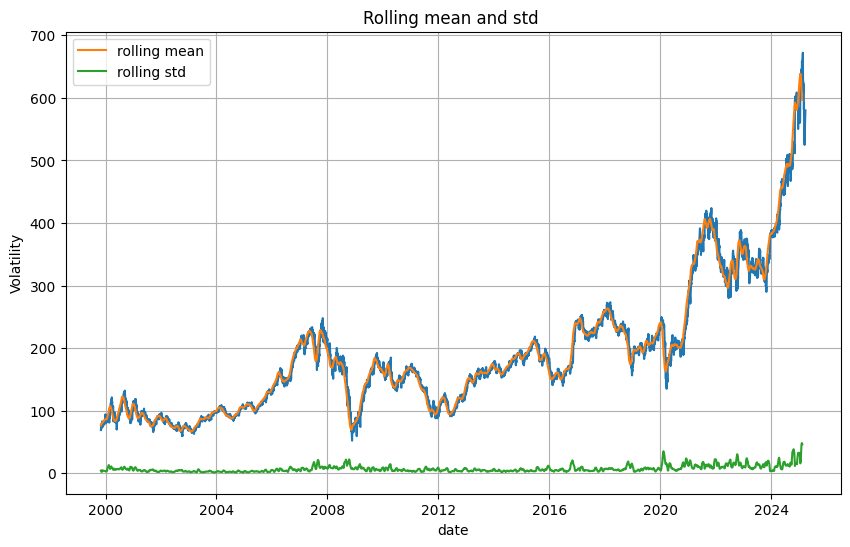

In [8]:
roll_mean = df["close"].rolling(window=30).mean()
roll_std = df["close"].rolling(window=30).std()

plt.figure(figsize=(10,6))
plt.plot(df.index,df["close"])
plt.plot(roll_mean.index,roll_mean, label="rolling mean")
plt.plot(roll_std.index,roll_std, label="rolling std")
plt.xlabel("date")
plt.ylabel("Volatility")
plt.title("Rolling mean and std ")
plt.grid()
plt.legend()

plt.show()

1. Rolling mean shows there is an increasing trend inspite of 2008 and 2020 breakdowns

2. Rolling std shows that the prices were stable more predictable and less volatile since 2008. In 2008, prices were fluctuating. In 2020 same scene occured and now also the market is unpredicatble 

## Calculating log return to stablaise variance

In [9]:
returns = np.log(df["close"]).diff().dropna()

1. Log return is calculated as log(value_t) - log(value_t-1)

2. Log returns are additive in nature, when we sum up all the log returns for a particular time period it gives a total log return over that time period

3. log return first takes log of todays value and then differences it with previous values log, whereas simple log first gives percentage of return for that particular day

##### Benefits:
1. It stabalizes the variance, it makes time series more stationary

2. Remember Waves length 
    1 of 20 and other of 5          (difference is 15)
    To avoid these big difference we apply log here in financial data  



In [10]:
returns

date
2025-03-21   -0.026127
2025-03-20   -0.004362
2025-03-19   -0.009536
2025-03-18   -0.010026
2025-03-17   -0.000798
                ...   
1999-11-05    0.009408
1999-11-04   -0.049516
1999-11-03   -0.019874
1999-11-02    0.014441
1999-11-01   -0.005319
Name: close, Length: 6386, dtype: float64

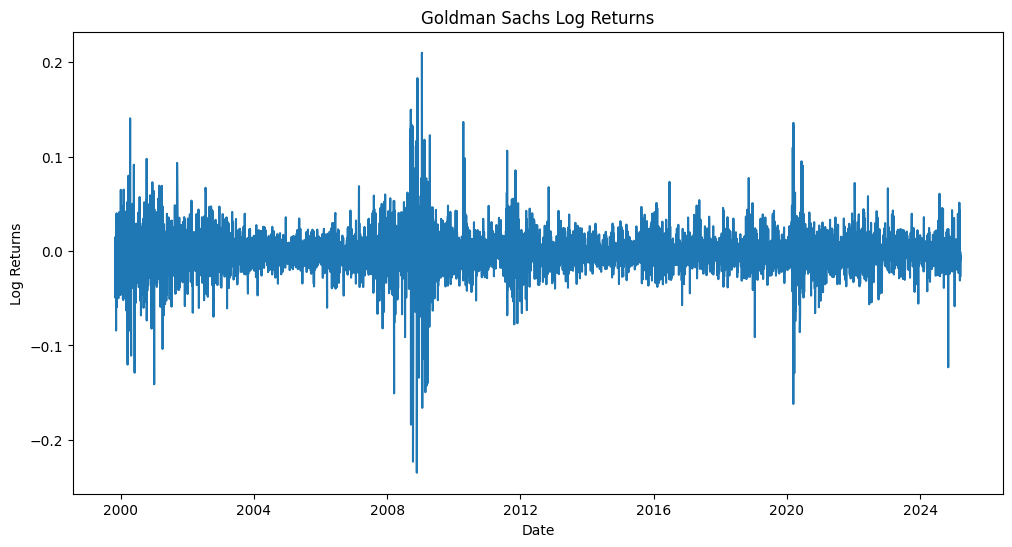

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(returns.index,returns)
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.title("Goldman Sachs Log Returns")
plt.show()


1. We could see using our previous plot that there is high variance in the year 2008. The data is highly volatile in the year 2000 as well.

## Lets check whether log_returns is stationary or not  

In [12]:
adf_returns = adfuller(returns)
adf_returns[1]

0.0

p-value is less then 0.05 means the series is stationary

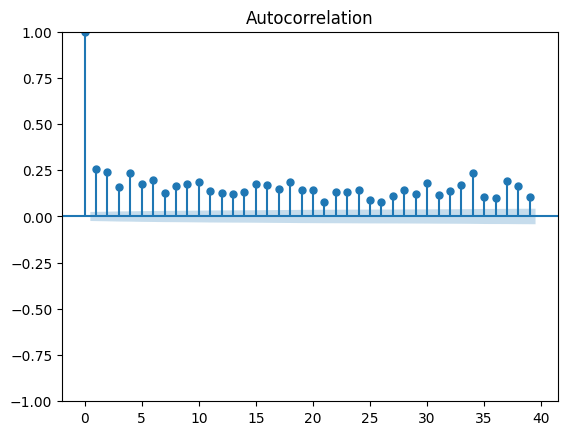

In [14]:
result = plot_acf(returns**2)
plt.show()

# Experimenting ARCH(1) model 

In [15]:
model_arch = arch_model(returns.dropna(), vol="ARCH", p=1)
model_fit_arch = model_arch.fit()
print(model_fit_arch.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 100783772850.3141
Iteration:      2,   Func. Count:     17,   Neg. LLF: 660816.9632959922
Iteration:      3,   Func. Count:     29,   Neg. LLF: 8046.384302233888
Iteration:      4,   Func. Count:     37,   Neg. LLF: 3297965286.6776085
Iteration:      5,   Func. Count:     48,   Neg. LLF: -15783.478320680908
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15783.478319116959
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                15783.5
Distribution:                  Normal   AIC:                          -31561.0
Method:            Maximum Likeli

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


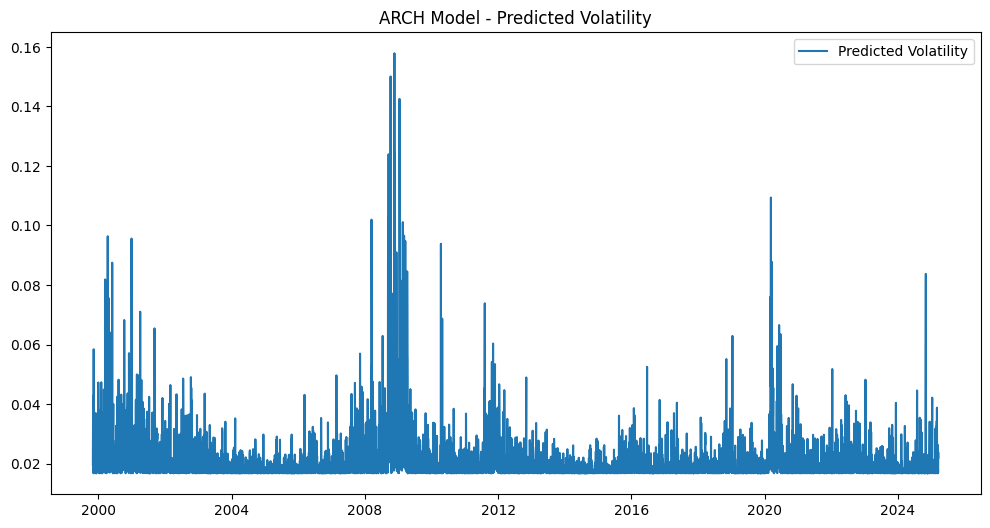

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_arch.conditional_volatility, label="Predicted Volatility")
plt.legend()
plt.title("ARCH Model - Predicted Volatility")
plt.show()


In [16]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_arch.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_arch.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

AIC = -31561.0
BIC = -31540.7

Mean Absolute Error (MAE): 0.02456600763966317
Root Mean Squared Error (RMSE): 0.03175518604155564


# Experimenting with ARCH(2)

In [17]:
model_arch2 = arch_model(returns.dropna(), vol="ARCH", p=2)
model_fit_arch2 = model_arch2.fit()
print(model_fit_arch2.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 69790596262.57964
Iteration:      2,   Func. Count:     19,   Neg. LLF: 19828.310594288094
Iteration:      3,   Func. Count:     30,   Neg. LLF: 229456622.72993934
Iteration:      4,   Func. Count:     43,   Neg. LLF: 19131.1273947304
Iteration:      5,   Func. Count:     54,   Neg. LLF: 61776.50614675671
Iteration:      6,   Func. Count:     65,   Neg. LLF: 1769844.3625099522
Iteration:      7,   Func. Count:     78,   Neg. LLF: 13946.471389374197
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16041.493679807762
            Iterations: 9
            Function evaluations: 85
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Lik

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


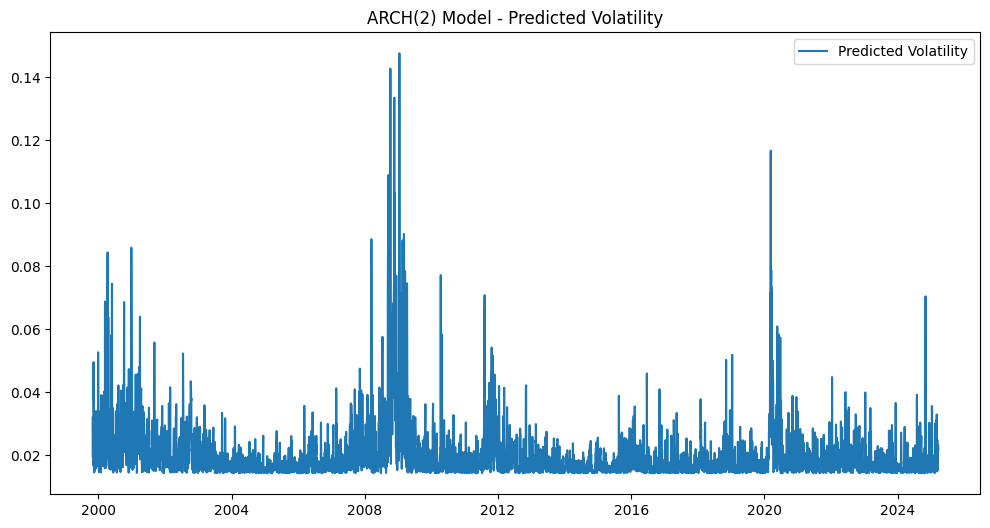

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_arch2.conditional_volatility, label="Predicted Volatility")
plt.legend()
plt.title("ARCH(2) Model - Predicted Volatility")
plt.show()

In [19]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_arch2.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_arch2.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

AIC = -32075.0
BIC = -32047.9


Mean Absolute Error (MAE): 0.02393503901839491
Root Mean Squared Error (RMSE): 0.031445308858046014


# Experimenting with GARCH(1,1)

In [20]:
model_garch = arch_model(returns.dropna(), vol="GARCH", p=1, q=1)
model_fit_garch = model_garch.fit()
print(model_fit_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10917467625.79786
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3858752.159520676
Iteration:      3,   Func. Count:     32,   Neg. LLF: 59986804.81622079
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1.2421530336969366e+16
Iteration:      5,   Func. Count:     57,   Neg. LLF: -16467.165961750736
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16467.16597238805
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16467.2
Distribution:                  Normal   AIC:                          -32926.3
Method:            Maximum Lik

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


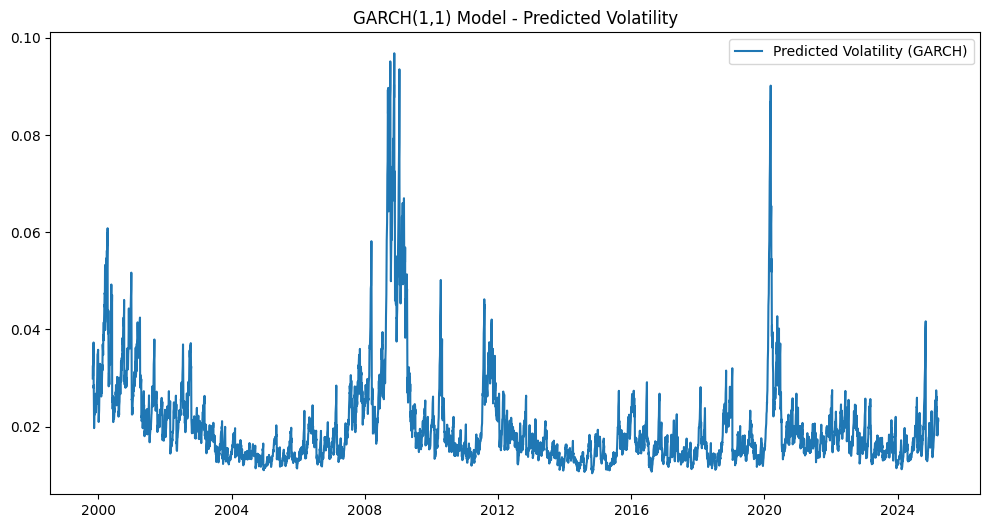

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_garch.conditional_volatility, label="Predicted Volatility (GARCH)")
plt.legend()
plt.title("GARCH(1,1) Model - Predicted Volatility")
plt.show()

In [23]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_garch.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_garch.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

AIC = -32926.3
BIC = -32899.3

Mean Absolute Error (MAE): 0.023399770547618368
Root Mean Squared Error (RMSE): 0.03143091850963621


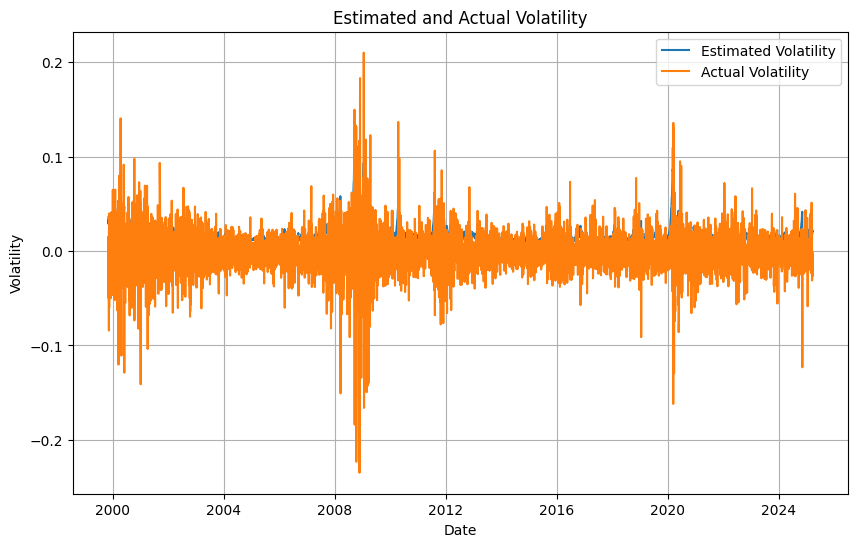

In [24]:
# Plot the estimated and actual volatility
plt.figure(figsize=(10, 6))
plt.plot(model_fit_garch.conditional_volatility.index, model_fit_garch.conditional_volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Volatility")
plt.legend()
plt.grid(True)

plt.show()

1. Issue here :
We can see that the volatility below 0 is not captured only 

2. What we achieved:
We can say that GARCH(1,1) is definately better then ARCH(1) and ARCH(2) by comapring mape and AIC, BIC values which decreased in GARCH(1,1)

3. What will do:
Lets decide the value of p and q for optimum forecasting 

# Estimating the value of p and q

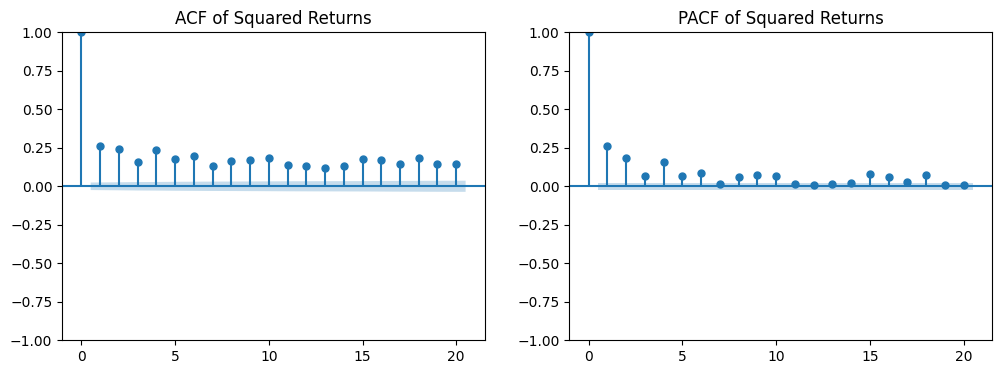

In [25]:
# Plot ACF and PACF of squared returns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(returns**2, lags=20, ax=axes[0])
axes[0].set_title("ACF of Squared Returns")

plot_pacf(returns**2, lags=20, ax=axes[1])
axes[1].set_title("PACF of Squared Returns")

plt.show()

Interpretation:
1. ACF plot shows that lag 3 showed reduction and we can determine q value to be 2 or 3 
2. PACF plot shows significant decrease in lag 3. Thus p value can be 2 or 3 

# Experimenting with GARCH(2,2)

In [26]:
model_garch2 = arch_model(returns.dropna(), vol="GARCH", p=2, q=2)
model_fit_garch2 = model_garch2.fit()
print(model_fit_garch2.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6295840353.7049675
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1.7417440895381856e+17
Iteration:      3,   Func. Count:     40,   Neg. LLF: 1527996379787.5078
Iteration:      4,   Func. Count:     56,   Neg. LLF: 1.2552742124349898e+16
Iteration:      5,   Func. Count:     72,   Neg. LLF: -16461.455558613437
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16461.455582574745
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16461.5
Distribution:                  Normal   AIC:                          -32910.9
Method:            Max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


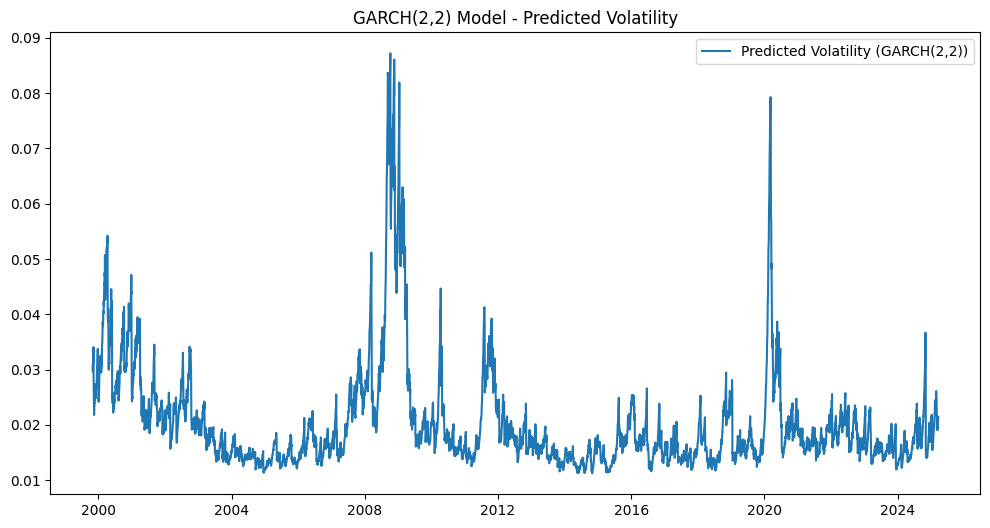

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_garch2.conditional_volatility, label="Predicted Volatility (GARCH(2,2))")
plt.legend()
plt.title("GARCH(2,2) Model - Predicted Volatility")
plt.show()

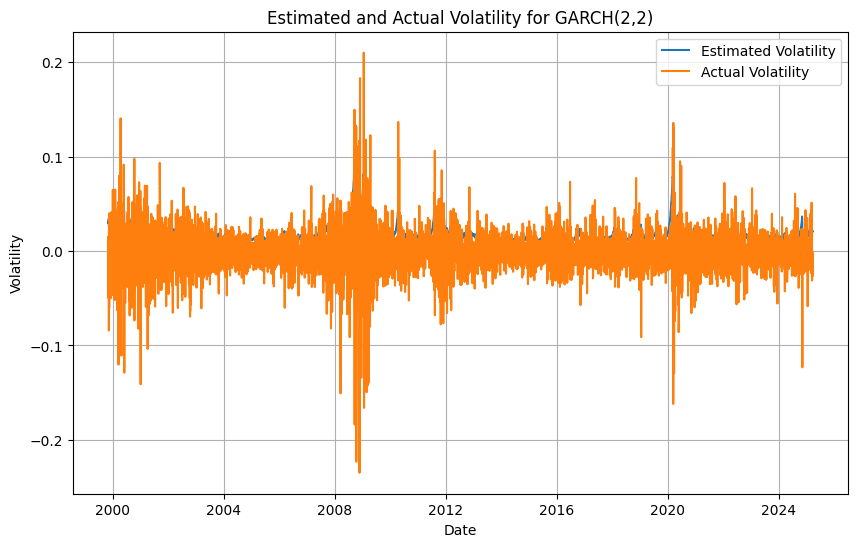

In [28]:
# Plot the estimated and actual volatility
plt.figure(figsize=(10, 6))
plt.plot(model_fit_garch2.conditional_volatility.index, model_fit_garch2.conditional_volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Volatility for GARCH(2,2)")
plt.legend()
plt.grid(True)

plt.show()

In [29]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_garch2.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_garch2.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

AIC = -32910.9
BIC = -32870.3

Mean Absolute Error (MAE): 0.023534084593666803
Root Mean Squared Error (RMSE): 0.03149163496023916


# Experimenting with GARCH(2,3)

In [30]:
model_garch3 = arch_model(returns.dropna(), vol="GARCH", p=2, q=3)
model_fit_garch3 = model_garch3.fit()
print(model_fit_garch3.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 1.8510250771484377e+21
Iteration:      2,   Func. Count:     25,   Neg. LLF: 8.560866499287245e+19
Iteration:      3,   Func. Count:     40,   Neg. LLF: -16465.03664307191
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16465.036628884045
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16465.0
Distribution:                  Normal   AIC:                          -32916.1
Method:            Maximum Likelihood   BIC:                          -32868.7
                                        No. Observations:                 6386
Date:       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


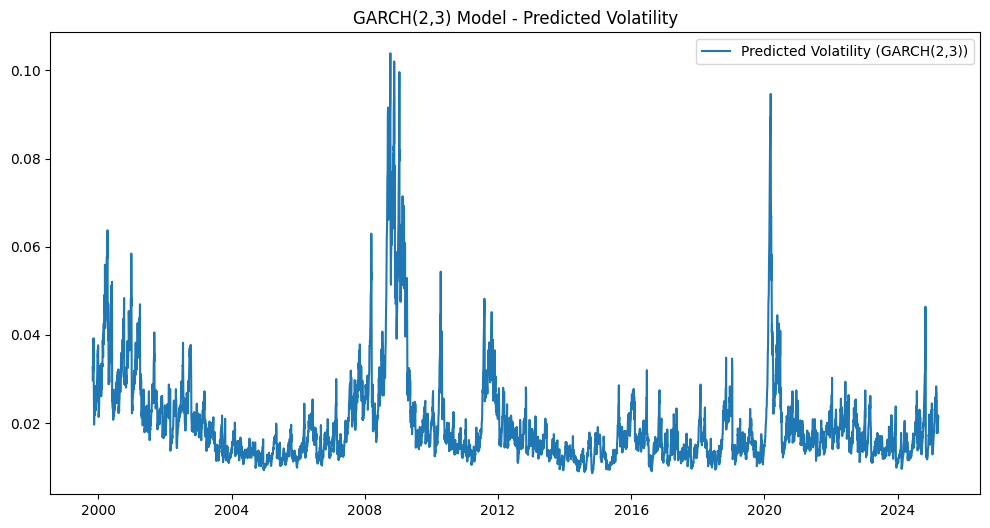

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_garch3.conditional_volatility, label="Predicted Volatility (GARCH(2,3))")
plt.legend()
plt.title("GARCH(2,3) Model - Predicted Volatility")
plt.show()

In [32]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_garch3.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_garch3.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

AIC = -32916.1
BIC = -32868.7

Mean Absolute Error (MAE): 0.02307125396627108
Root Mean Squared Error (RMSE): 0.03136863103497586


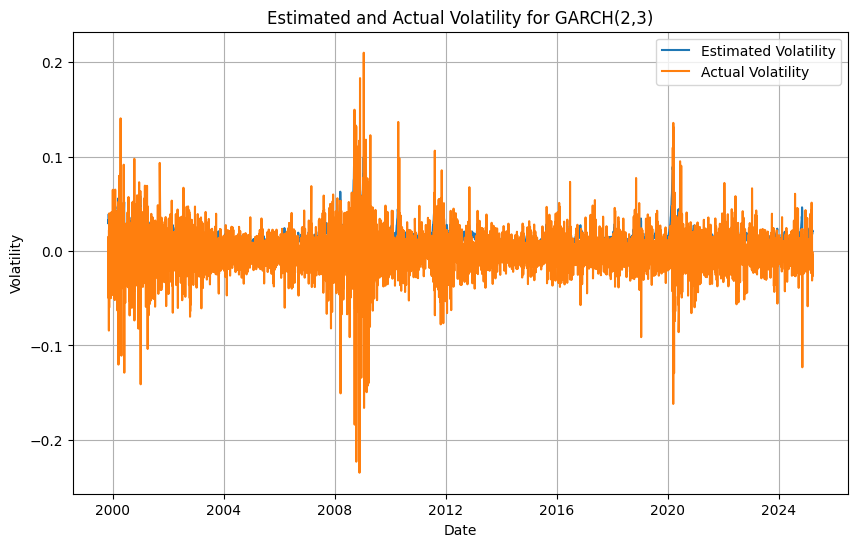

In [33]:
# Plot the estimated and actual volatility
plt.figure(figsize=(10, 6))
plt.plot(model_fit_garch3.conditional_volatility.index, model_fit_garch3.conditional_volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Volatility for GARCH(2,3)")
plt.legend()
plt.grid(True)

plt.show()

# Experimenting with GARCH(3,3)

In [34]:
model_garch4 = arch_model(returns.dropna(), vol="GARCH", p=3, q=3)
model_fit_garch4 = model_garch4.fit()
print(model_fit_garch4.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: 1.6684083736768288e+21
Iteration:      2,   Func. Count:     27,   Neg. LLF: 3.9062347281559496e+18
Iteration:      3,   Func. Count:     43,   Neg. LLF: -16456.6486715594
Optimization terminated successfully    (Exit mode 0)
            Current function value: -16456.64865867035
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16456.6
Distribution:                  Normal   AIC:                          -32897.3
Method:            Maximum Likelihood   BIC:                          -32843.2
                                        No. Observations:                 6386
Date:        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005074. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


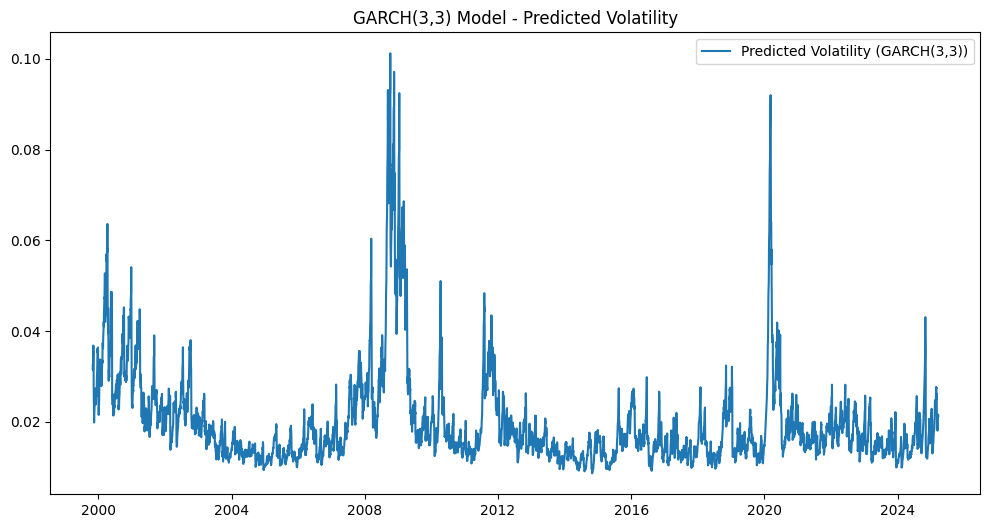

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_garch4.conditional_volatility, label="Predicted Volatility (GARCH(3,3))")
plt.legend()
plt.title("GARCH(3,3) Model - Predicted Volatility")
plt.show()

In [36]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_garch4.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_garch4.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

AIC = -32897.3
BIC = -32843.2

Mean Absolute Error (MAE): 0.02310115658121461
Root Mean Squared Error (RMSE): 0.0314004787997146


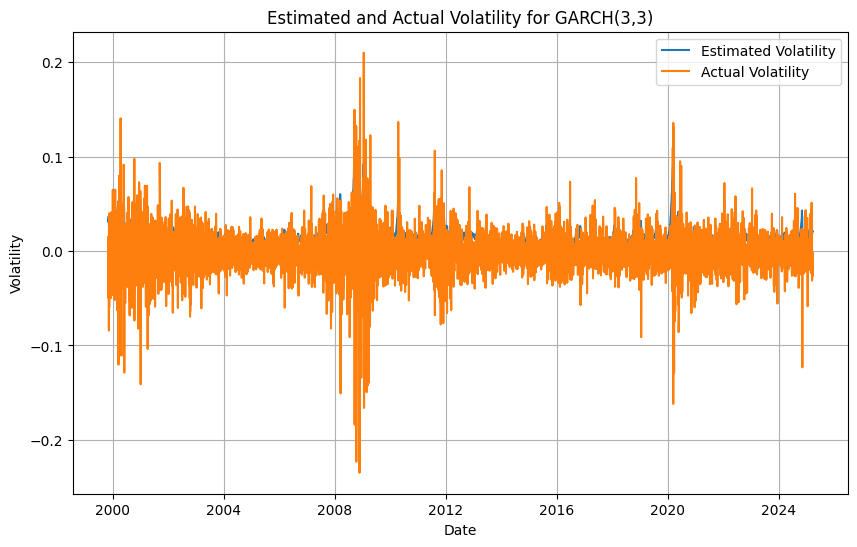

In [37]:
# Plot the estimated and actual volatility
plt.figure(figsize=(10, 6))
plt.plot(model_fit_garch4.conditional_volatility.index, model_fit_garch4.conditional_volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Volatility for GARCH(3,3)")
plt.legend()
plt.grid(True)

plt.show()

### In GARCH(2,3) AIC and BIC values were compartively good then GARCH(3,3)
### Also the error is less in GARCH(2,3) 

### Thus, GARCH(2,3) is capturing volatility well